In [1]:
import tensorflow as tf
import numpy as np

import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [2]:
def DisplayArray(a, fmt='png', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

In [3]:
sess = tf.InteractiveSession()

In [4]:
def make_kernel(a):
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=1)

def conv(x, k):
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

def laplace(x):
    laplace_k = make_kernel([[0.5, 1., 0.5],
                             [1., -6., 1.],
                             [0.5, 1., 0.5]])
    return conv(x, laplace_k)

In [30]:
M = 400
N = 710
u_init = np.zeros([M, N], dtype=np.float32)
ut_init = np.zeros([M, N], dtype=np.float32)

n_drops = 150
for n in range(n_drops):
    a = np.random.randint(0, M, 2)
    b = np.random.randint(0, N, 2)
    u_init[a, b] = np.random.uniform()

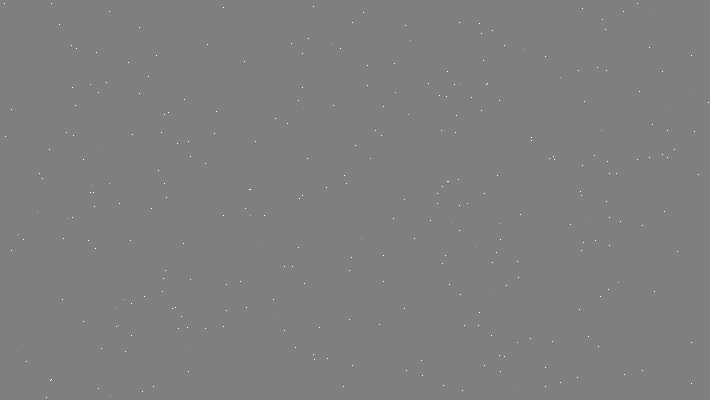

In [31]:
DisplayArray(u_init, rng=[-0.1, 0.1])

In [41]:
# PDE parameters
# time resolution
eps = tf.placeholder_with_default(0.01, shape=())
# wave damping
damping = tf.placeholder_with_default(0.05, shape=())
# reaction coefficient
reaction = tf.placeholder_with_default(0.05, shape=())

# Simulation state variables
U = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# PDE FDM updates
U_ = U + eps * Ut
# Ut_ = Ut + eps * (laplace(U) - damping * Ut)
Ut_ = laplace(U) + reaction * U * (1 - U / 0.5) - damping * Ut

# Operation to update the state
step = tf.group(
    U.assign(U_),
    Ut.assign(Ut_))

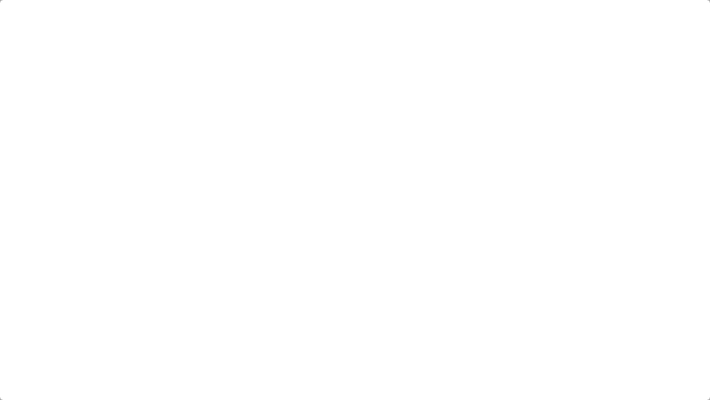

Average seconds per frame: 0.0125205390453


In [44]:
import time

sess.run(tf.global_variables_initializer())

T = 1000
t0 = time.time()
for i in range(T):
    step.run({eps: 0.1, damping: 1, reaction: 0.05})
    DisplayArray(U.eval(), rng=[-0.1, 0.1])
t1 = time.time()
print('Average seconds per frame: {}'.format((t1 - t0) / T))